In [5]:
import mindspore.nn as nn
from mindspore import dtype as mstype
import mindspore.dataset as ds
import mindspore.dataset.vision.c_transforms as C
import mindspore.dataset.transforms.c_transforms as C2
from mindspore import context
import matplotlib.pyplot as plt
from mindspore.train.callback import Callback
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor
import os
from mindspore import Model
from mindspore.nn import Accuracy
from mindspore.nn import SoftmaxCrossEntropyWithLogits
from VGG11 import VGG11
from Resnet18 import ResNet18

context.set_context(mode=context.GRAPH_MODE, device_target="GPU")


def create_dataset(data_home, repeat_num=1, batch_size=32, do_train=True, device_target="GPU"):
    """
    create data for next use such as training or inferring
    """

    cifar_ds = ds.Cifar10Dataset(data_home, num_parallel_workers=8, shuffle=True)

    c_trans = []
    if do_train:
        c_trans += [
            C.Resize((224, 224)),
            C.RandomHorizontalFlip(prob=0.5)
        ]

    c_trans += [
        C.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]),
        C.HWC2CHW()
    ]

    type_cast_op = C2.TypeCast(mstype.int32)
    
    #规范输出格式
    cifar_ds = cifar_ds.map(operations=type_cast_op, input_columns="label", num_parallel_workers=8)
    cifar_ds = cifar_ds.map(operations=c_trans, input_columns="image", num_parallel_workers=8)

    cifar_ds = cifar_ds.batch(batch_size, drop_remainder=True)
    cifar_ds = cifar_ds.repeat(repeat_num)

    return cifar_ds


class StepLossAccInfo(Callback):
    def __init__(self, model, eval_dataset, steps_loss, steps_eval):
        self.model = model
        self.eval_dataset = eval_dataset
        self.steps_loss = steps_loss
        self.steps_eval = steps_eval

    def step_end(self, run_context):
        cb_params = run_context.original_args()
        # cur_epoch = cb_params.cur_epoch_num
        # cur_step = (cur_epoch-1)*1562 + cb_params.cur_step_num
        cur_step = cb_params.cur_step_num
        if cur_step % 10 == 0:
            self.steps_loss["loss_value"].append(str(cb_params.net_outputs))
            self.steps_loss["step"].append(str(cur_step))
        if cur_step % 100 == 0:
            acc = self.model.eval(self.eval_dataset, dataset_sink_mode=False)
            self.steps_eval["step"].append(cur_step)
            self.steps_eval["acc"].append(acc["Accuracy"])


def train(net_type, epoch_size):
    # 设置网络结构
    if net_type == "vgg11":
        net = VGG11()
    elif net_type == 'resnet18':
        net = ResNet18()
    # 设置损失函数和优化器
    loss_fn = SoftmaxCrossEntropyWithLogits(sparse=True, reduction="mean")
    optimizer = nn.Adam(net.trainable_params(), learning_rate=1e-3)
    # 初始化模型
    model = Model(net, loss_fn=loss_fn, optimizer=optimizer, metrics={"Accuracy": Accuracy()})
    # 设置训练数据集和测试数据集
    ds_train_path = "./datasets/cifar10/train/"
    ds_test_path = "./datasets/cifar10/test/"
    ds_train = create_dataset(ds_train_path)
    ds_test = create_dataset(ds_test_path)
    # 设置模型保存的路径，删除掉之前训练保存的模型
    model_path = "./models/ckpt/mindspore_vision_application/"
    os.system('rm -f {0}*.ckpt {0}*.meta {0}*.pb'.format(model_path))
    # 得到每个batch的训练步数
    batch_num = ds_train.get_dataset_size()
    # 设置与模型保存相关的参数
    config_ck = CheckpointConfig(save_checkpoint_steps=batch_num, keep_checkpoint_max=1)
    ckpoint_cb = ModelCheckpoint(prefix="train_" + net_type + "_cifar10", directory=model_path, config=config_ck)
    # 设置损失记录器，参数是打印Loss信息的步长，142的意思是每142步打印一次loss信息
    loss_cb = LossMonitor(142)
    # 设置记录损失的数据结构，用于在后面打印曲线图像
    steps_loss = {"step": [], "loss_value": []}
    steps_eval = {"step": [], "acc": []}
    step_loss_acc_info = StepLossAccInfo(model, ds_test, steps_loss, steps_eval)
    # 执行模型的训练
    print("begin training...")
    model.train(epoch_size, ds_train, callbacks=[ckpoint_cb, loss_cb, step_loss_acc_info], dataset_sink_mode=False)
    # model.train(epoch_size, ds_train, callbacks=[ckpoint_cb, loss_cb, step_loss_acc_info])
    # 训练完后，对模型进行测试，打印正确率
    res = model.eval(ds_test)
    print("result: ", res)
    # 利用训练中保存的信息，打印训练损失曲线和训练正确率曲线
    steps = steps_loss["step"]
    loss_value = steps_loss["loss_value"]
    steps = list(map(int, steps))
    loss_value = list(map(float, loss_value))
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(steps, loss_value, color="red")
    plt.xlabel("Steps")
    plt.ylabel("Loss_value")
    plt.title("Change chart of model loss value")
    steps = steps_eval["step"]
    acc_value = steps_eval["acc"]
    steps = list(map(int, steps))
    loss_value = list(map(float, acc_value))
    plt.subplot(1, 2, 2)
    plt.plot(steps, acc_value, color="blue")
    plt.xlabel("Steps")
    plt.ylabel("Acc_value")
    plt.title("Change chart of model acc value")
    plt.show()

begin training...
epoch: 1 step: 142, loss is 2.167940139770508
epoch: 1 step: 284, loss is 1.8468449115753174
epoch: 1 step: 426, loss is 1.880118489265442
epoch: 1 step: 568, loss is 1.8674982786178589
epoch: 1 step: 710, loss is 1.8018742799758911
epoch: 1 step: 852, loss is 1.838316559791565
epoch: 1 step: 994, loss is 1.850793480873108
epoch: 1 step: 1136, loss is 1.8718093633651733
epoch: 1 step: 1278, loss is 1.6579965353012085
epoch: 1 step: 1420, loss is 1.67518949508667
epoch: 1 step: 1562, loss is 1.6673589944839478
epoch: 2 step: 142, loss is 1.5711640119552612
epoch: 2 step: 284, loss is 1.566478967666626
epoch: 2 step: 426, loss is 1.570229411125183
epoch: 2 step: 568, loss is 1.3636270761489868
epoch: 2 step: 710, loss is 1.2042827606201172
epoch: 2 step: 852, loss is 1.4560620784759521
epoch: 2 step: 994, loss is 1.6123862266540527
epoch: 2 step: 1136, loss is 1.1563230752944946
epoch: 2 step: 1278, loss is 1.843074917793274
epoch: 2 step: 1420, loss is 1.56219434738159

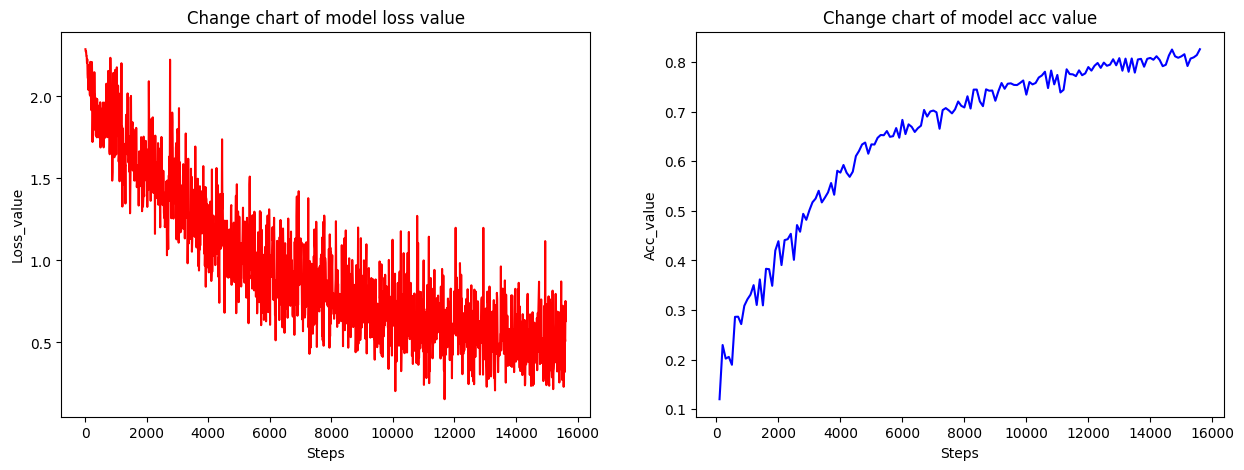

In [2]:
train("resnet18", 10)

In [9]:
from mindspore.train.callback import ModelCheckpoint
from mindspore import load_checkpoint, load_param_into_net
from mindspore import context
from VGG11 import VGG11
from Resnet18 import ResNet18
from mindspore import Model
from mindspore.nn import Accuracy
from mindspore.nn import SoftmaxCrossEntropyWithLogits
context.set_context(mode=context.GRAPH_MODE, device_target="GPU")
ds_test_path = "./datasets/cifar10/test/"
vgg = VGG11()
loss = SoftmaxCrossEntropyWithLogits(sparse=True, reduction="mean")
# 将模型参数存入parameter的字典中
param_dict = load_checkpoint("models/ckpt/mindspore_vision_application/train_vgg11_cifar10-10_1562.ckpt")
# 将参数加载到网络中
load_param_into_net(vgg, param_dict)
model = Model(vgg, loss, metrics={"accuracy"})
dataset_eval = create_dataset(ds_test_path)
acc = model.eval(dataset_eval)
print(acc)



{'accuracy': 0.8293269230769231}
